In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [2]:
files = ['../input/test_identity.csv', 
         '../input/test_transaction.csv',
         '../input/train_identity.csv',
         '../input/train_transaction.csv',
         '../input/sample_submission.csv']

In [3]:
%%time
def load_data(file):
    return pd.read_csv(file)

with multiprocessing.Pool() as pool:
    test_id, test_tr, train_id, train_tr, sub = pool.map(load_data, files)

CPU times: user 3.87 s, sys: 8.31 s, total: 12.2 s
Wall time: 56.4 s


In [4]:
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

del test_id, test_tr, train_id, train_tr
gc.collect()

71

In [5]:
rename_id_cols = {}
for col in test.columns:
    if col.startswith('id'):
        rename_id_cols[col] = '_'.join(col.split('-'))
test.rename(columns=rename_id_cols, inplace=True)

# **Select 159 useful features based on recursive feature elimination notebook**

In [6]:
useful_features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M8', 'M9', 'V4', 'V5', 'V12', 'V13', 'V19', 'V20', 'V30', 'V34', 'V35', 'V36',
                   'V37', 'V38', 'V44', 'V45', 'V47', 'V53', 'V54', 'V56', 'V57', 'V58', 'V61', 'V62', 'V70', 'V74', 'V75', 'V76',
                   'V78', 'V82', 'V83', 'V87', 'V91', 'V94', 'V96', 'V97', 'V99', 'V126', 'V127', 'V128', 'V130', 'V131', 'V139',
                   'V143', 'V149', 'V152', 'V160', 'V165', 'V170', 'V187', 'V189', 'V201', 'V203', 'V204', '207', 'V208', 'V209',
                   'V210', 'V212', 'V217', 'V221', 'V222', 'V234', 'V257', 'V258', 'V261', 'V264', 'V265', 'V266', 'V267', 'V268',
                   'V271', 'V274', 'V275', 'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V289', 'V291', 'V292',
                   'V294', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V323', 'V324', 'V332', 'V333',
                   'id_01', 'id_02', 'id_05', 'id_06', 'id_09', 'id_13', 'id_14', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31',
                   'id_33', 'id_38', 'DeviceType', 'DeviceInfo']

In [7]:
cols_to_drop = [col for col in train.columns if col not in useful_features]
cols_to_drop.remove('isFraud')
cols_to_drop.remove('TransactionID')
cols_to_drop.remove('TransactionDT')

In [8]:
print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

273 features are going to be dropped for being useless


# **Feature engineering**

In [9]:
# New feature - decimal part of the transaction amount
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

# Count encoding for card1 feature. 
train['card1_count_full'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
test['card1_count_full'] = test['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

# https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

# Some features interaction
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))
    
for feature in ['id_34', 'id_36']:
    if feature in useful_features:
        # Count encoded for both train and test
        train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
        test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
        
for feature in ['id_01', 'id_31', 'id_33', 'id_35', 'id_36']:
    if feature in useful_features:
        # Count encoded separately for train and test
        train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
        test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))

In [10]:
for col in tqdm_notebook(train.columns):
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))   

In [11]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

In [12]:
del train
gc.collect()

63

In [13]:
X.shape, test.shape

((590540, 175), (506691, 175))

# **Using Bayesian optimization to get the parameters**

In [14]:
# https://www.kaggle.com/vincentlugat/ieee-lgb-bayesian-opt#2.-Bayesian-Optimisation
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [15]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999998	valid_1's auc: 0.905407
Early stopping, best iteration is:
[834]	training's auc: 0.99998	valid_1's auc: 0.905674
Fold 1 finished in 0:02:13.828854
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999965	valid_1's auc: 0.923825
Early stopping, best iteration is:
[813]	training's auc: 0.999804	valid_1's auc: 0.924367
Fold 2 finished in 0:04:17.108624
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999532	valid_1's auc: 0.917039
Early stopping, best iteration is:
[1038]	training's auc: 0.99963	valid_1's auc: 0.91712
Fold 3 finished in 0:07:18.011092
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.998097	valid_1's auc: 0.936899
Early stopping, best iteration is:
[1142]	training's auc: 0.998951	valid_1's a

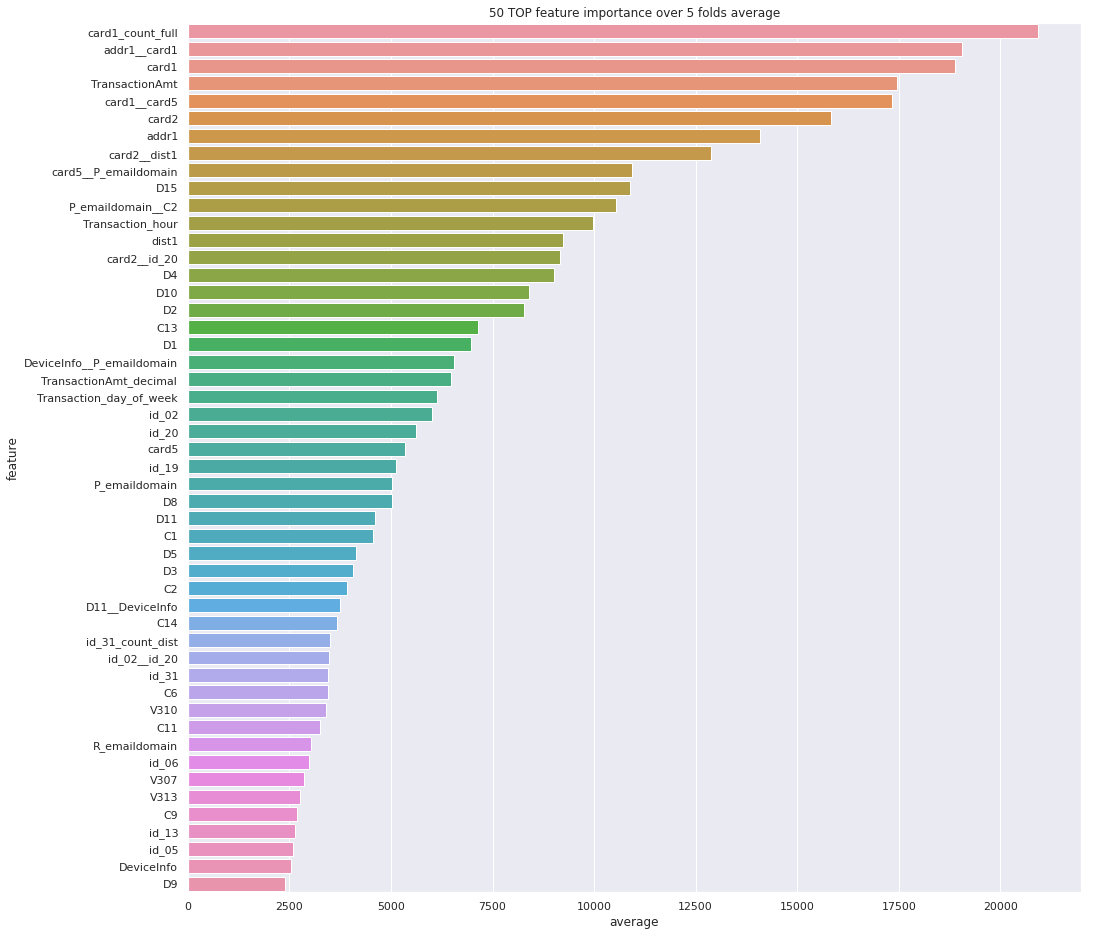

In [16]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [17]:
# clf right now is the last model, trained with 80% of data and validated with 20%
best_iter = clf.best_iteration

In [18]:
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X, y)

LGBMClassifier(bagging_fraction=0.4181193142567742, bagging_seed=11,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.3797454081646243, importance_type='split',
               learning_rate=0.006883242363721497, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.03454472573214212,
               min_data_in_leaf=106, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=1258, num_leaves=491,
               objective='binary', random_state=47,
               reg_alpha=0.3899927210061127, reg_lambda=0.6485237330340494,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0, verbosity=-1)

In [19]:
sub['isFraud'] = clf.predict_proba(test)[:, 1]

In [20]:
sub.to_csv('LGBM_submission.csv', index=False)